In [1]:
!pip install blackjax
!pip install distrax
!pip install flax
!pip install sgmcmcjax
!pip3 install kernax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 7.0 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import scienceplots

import jax
from datetime import date
import jax.numpy as jnp
import distrax

plt.style.use('science')
#plt.rcParams["axes.spines.right"] = False
#plt.rcParams["axes.spines.top"] = False
#plt.rcParams["figure.figsize"] = (12, 8)

import flax.linen as nn
import jax.scipy.stats as stats

2025-01-24 09:42:41.998901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 09:42:42.139611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 09:42:42.173168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 09:42:43.846642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Definimos el modelo y la función de verosimilitud

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(noise=0.2, random_state=0, n_samples=1000)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
X_train.shape

(670, 2)

In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [22]:
plt.style.use(['science','scatter','high-contrast'])

fig, ax = plt.subplots()
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="C0", label="Class 0")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="C1", label="Class 1")
ax.autoscale(tight=True)
ax.legend()
ax.set(xlabel="X1", ylabel="X2", title="Binary classification data set");
fig.savefig("figures/binary_train_dataset.pdf", dpi=300)
plt.close()

In [15]:
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel, build_sghmc_kernel

class SimpleMLP(nn.Module):

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    x = nn.Dense(32, name=f'layer1')(x)
    x = nn.relu(x)
    x = nn.Dense(64, name=f'layer2')(x)
    x = nn.relu(x)
    x = nn.Dense(1, name=f'layer3')(x)
    x = nn.sigmoid(x)
    return x

model = SimpleMLP()

def logprior(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return distrax.Normal(0., 1.).log_prob(flat_params).sum()

def loglikelihood(params, X,y):
    y_pred=model.apply({'params':(params)}, X)
    return distrax.Bernoulli(y_pred).log_prob(y.reshape(-1,1)).sum()


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def run_sgmcmc(key, Nsamples, init_fn, my_kernel, get_params):
    "Run SGMCMC sampler and return the test accuracy list"
    loss = list()
    samples=list()
    key, subkey1,subkey2 = jax.random.split(key,3)
    params = model.init(subkey1, jnp.ones_like(X_train[:2]))['params']
    state = init_fn(subkey2, params)

    for i in range(Nsamples):
        key, subkey = jax.random.split(key)
        state = my_kernel(i, subkey, state)
        loss.append(-1.0*loglikelihood(get_params(state),X_test,y_test))
        position={'params':(get_params(state))}
        samples.append(position)
        if (i%(Nsamples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [18]:
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel, build_sghmc_kernel

num_training_steps=8000
mini_batch=64
learning_rate=1e-4

data=(X_train,y_train)
init_fn, sgld_kernel, get_params = build_sgld_kernel(learning_rate, loglikelihood, logprior, data, mini_batch)
sgld_kernel = jax.jit(sgld_kernel)
rng_key = jax.random.PRNGKey(0)


In [19]:
sgld_samples,loss = run_sgmcmc(rng_key, num_training_steps, init_fn, sgld_kernel, get_params)

iteration 0, loss 242.32
iteration 800, loss 183.84
iteration 1600, loss 181.29
iteration 2400, loss 180.98
iteration 3200, loss 177.55
iteration 4000, loss 174.04
iteration 4800, loss 173.85
iteration 5600, loss 169.73
iteration 6400, loss 171.52
iteration 7200, loss 177.09


In [26]:
fig, ax = plt.subplots()
ax.plot(loss)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set(xlabel="epoch", ylabel="negative log-likelihood", title="SGLD sample path");
fig.savefig("figures/sgld_nll.pdf", dpi=300)
plt.close()

In [27]:
jax.tree.map(lambda p:p.shape,sgld_samples[0])

{'params': {'layer1': {'bias': (32,), 'kernel': (2, 32)},
  'layer2': {'bias': (64,), 'kernel': (32, 64)},
  'layer3': {'bias': (1,), 'kernel': (64, 1)}}}

# INT 8 Quantization

[Quantization Blog]https://leimao.github.io/article/Neural-Networks-Quantization/

https://proceedings.mlr.press/v162/zhang22ag/zhang22ag.pdf

In [28]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = jnp.round(1 / s * x + z, decimals=0)
    x_q = jnp.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q.astype(jnp.uint8)


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(jnp.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(jnp.int32)
    x = s * (x_q - z)
    x = x.astype(jnp.float16)
    return x


def generate_quantization_constants_scale(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    return s

def generate_quantization_constants_bias(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    z = jnp.int8((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return z



In [29]:
def tree_stack(trees):
    return jax.tree.map(lambda *v: jnp.stack(v), *trees)

def tree_unstack(tree):
    leaves, treedef = jax.tree.flatten(tree)
    return [treedef.unflatten(leaf) for leaf in zip(*leaves, strict=True)]

stacked_samples=tree_stack(sgld_samples)
alpha=jax.tree.map(lambda p:jnp.min(p,axis=0),stacked_samples)
beta=jax.tree.map(lambda p:jnp.max(p,axis=0),stacked_samples)
b=8
alpha_q = 0
beta_q = 255
s=jax.tree.map(lambda a,b:generate_quantization_constants_scale(a,b,alpha_q,beta_q),alpha,beta)
z=jax.tree.map(lambda a,b:generate_quantization_constants_bias(a,b,alpha_q,beta_q),alpha,beta)


In [30]:
quantized_stacked_samples=jax.tree.map(lambda x,s,z:quantization(x,s,z,alpha_q,beta_q),stacked_samples,s,z)

In [53]:
jax.tree.map(lambda p:p.dtype,quantized_stacked_samples)

{'params': {'layer1': {'bias': dtype('uint8'), 'kernel': dtype('uint8')},
  'layer2': {'bias': dtype('uint8'), 'kernel': dtype('uint8')},
  'layer3': {'bias': dtype('uint8'), 'kernel': dtype('uint8')}}}

In [54]:
jax.tree.map(lambda p:p.dtype,stacked_samples)

{'params': {'layer1': {'bias': dtype('float32'), 'kernel': dtype('float32')},
  'layer2': {'bias': dtype('float32'), 'kernel': dtype('float32')},
  'layer3': {'bias': dtype('float32'), 'kernel': dtype('float32')}}}

In [43]:
dequantized_stacked_samples=jax.tree.map(
    lambda x,s,z:dequantization(x,s,z),quantized_stacked_samples,s,z)

In [37]:
dequantized_samples=tree_unstack(dequantized_stacked_samples)

In [91]:
jax.tree.map(lambda p,q:jnp.linalg.norm(p-q),dequantized_stacked_samples,stacked_samples)

{'params': {'layer1': {'bias': Array(33.994297, dtype=float32),
   'kernel': Array(173.67186, dtype=float32)},
  'layer2': {'bias': Array(59.584972, dtype=float32),
   'kernel': Array(505.40366, dtype=float32)},
  'layer3': {'bias': Array(0.64191675, dtype=float32),
   'kernel': Array(72.39763, dtype=float32)}}}

In [96]:
fp32_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,stacked_samples))[0])*1e-6

In [95]:
int8_size=sum(jax.tree.flatten(jax.tree.map(lambda p:p.nbytes,quantized_stacked_samples))[0])*1e-6

In [107]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(fp32_size))

Tamaño Muestras FP32 : 72.74Mb


In [108]:
print('Tamaño Muestras FP32 : {0:.2f}Mb'.format(int8_size))

Tamaño Muestras FP32 : 18.18Mb


# Pruebas de Clasificacion

In [109]:
import numpy as np

params=sgld_samples[-1]
y_pred=np.asarray(model.apply(params, X_test)>0.5)

In [110]:
from matplotlib.colors import ListedColormap
h=0.1
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_grid = jnp.c_[xx.ravel(), yy.ravel()]
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# ax = plt.plot()
# Plot the training points
#ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
#ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
#ax.set_xlim(xx.min(), xx.max())

In [111]:
X_grid.shape

(2809, 2)

In [ ]:
mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(stacked_samples, X_grid).mean(axis=0)
q_mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(dequantized_stacked_samples, X_grid).mean(axis=0)


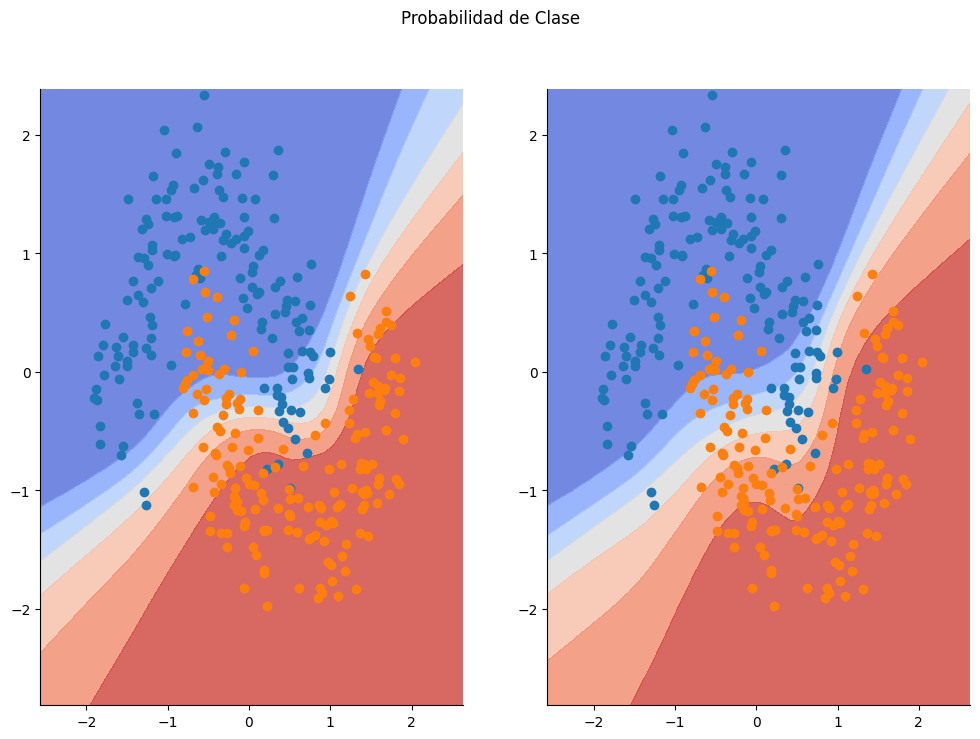

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Probabilidad de Clase')
ax1.contourf(xx, yy, np.array(mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax1.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax1.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")
#ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax2.contourf(xx, yy, np.array(q_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax2.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0",label="Class 0")
ax2.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")

In [25]:
preds=jax.vmap(model.apply,in_axes=(0,None))(stacked_samples, X_test)

In [26]:
q_preds=jax.vmap(model.apply,in_axes=(0,None))(dequantized_stacked_samples, X_test)

In [27]:
mean_pred=jnp.mean(preds,axis=0)

In [28]:
q_mean_pred=jnp.mean(q_preds,axis=0)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.asarray(mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       153
           1       0.92      0.80      0.85       177

    accuracy                           0.85       330
   macro avg       0.86      0.86      0.85       330
weighted avg       0.86      0.85      0.85       330



In [30]:
print(classification_report(y_test, np.asarray(q_mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       153
           1       0.90      0.79      0.84       177

    accuracy                           0.84       330
   macro avg       0.85      0.85      0.84       330
weighted avg       0.85      0.84      0.84       330



# Metricas de Muestreo

In [36]:
from kernax import SteinThinning

In [37]:
jax.tree.map(lambda p:p.shape,stacked_samples)

{'params': {'layer1': {'bias': (8000, 10), 'kernel': (8000, 2, 10)},
  'layer2': {'bias': (8000, 10), 'kernel': (8000, 10, 10)},
  'layer3': {'bias': (8000, 1), 'kernel': (8000, 10, 1)}}}

In [42]:
log_probs=jax.vmap(loglikelihood,in_axes=(0,None,None))(stacked_samples['params'],X_test,y_test)

In [55]:
score_fn=jax.grad(loglikelihood)

In [74]:
scores={'params':jax.vmap(score_fn,in_axes=(0,None,None))(stacked_samples['params'],X_test,y_test)}

In [99]:
from kernax.utils import median_heuristic

flatten_stacked_samples=jax.tree.map(lambda p:p.reshape(8000,-1),stacked_samples)
length_scales=jax.tree.map(lambda p:median_heuristic(p),flatten_stacked_samples)


In [100]:
flatten_scores=jax.tree.map(lambda p:p.reshape(8000,-1),scores)

In [101]:
from kernax import SteinThinning

stein_fn=jax.tree.map(lambda x,s,l:SteinThinning(x,s,l),flatten_stacked_samples,flatten_scores,length_scales)

In [105]:
indices=jax.tree.map(lambda f:f(1000),stein_fn)

In [106]:
thinned_samples=jax.tree.map(lambda x,i:x[i],stacked_samples,indices)

In [107]:
jax.tree.map(lambda p:p.shape,thinned_samples)

{'params': {'layer1': {'bias': (1000, 10), 'kernel': (1000, 2, 10)},
  'layer2': {'bias': (1000, 10), 'kernel': (1000, 10, 10)},
  'layer3': {'bias': (1000, 1), 'kernel': (1000, 10, 1)}}}

In [108]:
thinned_preds=jax.vmap(model.apply,in_axes=(0,None))(thinned_samples, X_test)

In [110]:
thinned_mean_pred=jnp.mean(thinned_preds,axis=0)

In [112]:

print(classification_report(y_test, np.asarray(thinned_mean_pred>0.5)))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       153
           1       0.95      0.71      0.81       177

    accuracy                           0.82       330
   macro avg       0.84      0.83      0.82       330
weighted avg       0.85      0.82      0.82       330



In [113]:
t_mean_grid_pred=jax.vmap(model.apply,in_axes=(0,None))(thinned_samples, X_grid).mean(axis=0)

In [115]:
t_mean_grid_pred.shape

(2809, 1)

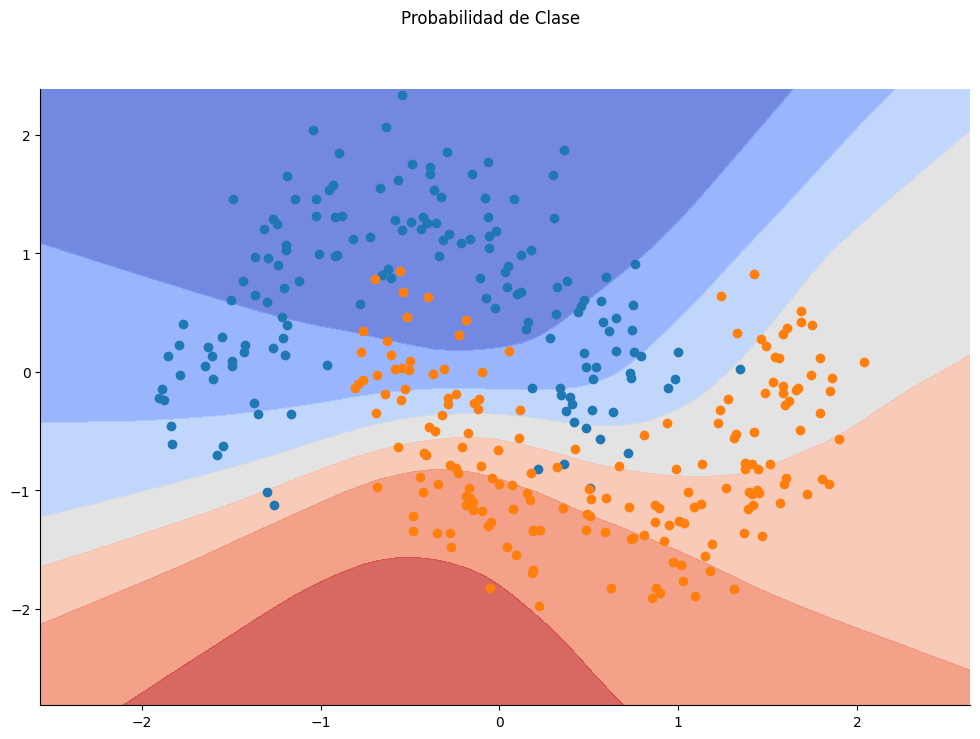

In [116]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Probabilidad de Clase')
ax.contourf(xx, yy, np.array(t_mean_grid_pred).reshape(xx.shape), cmap="coolwarm", alpha=0.8)
ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color="C0", label="Class 0")
ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color="C1", label="Class 1")